In [1]:
import keras
from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [2]:
%matplotlib inline
import keras 
import numpy as np 
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import itertools
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense, Flatten, Dropout
from tensorflow.python.client import device_lib
# keras library import  for Saving and loading model and weights
from keras.models import model_from_json
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Conv2DTranspose, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add
import tensorflow as tf

In [3]:
def model():
    model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = tf.keras.layers.Conv2D(1024, (7,7),padding = "SAME", activation = "relu", name = "fc5")(model.layers[-1].output)
    x = tf.keras.layers.Conv2D(1024, (7,7),padding = "SAME", activation = "relu", name = "fc6")(x)
    x = tf.keras.layers.Conv2D(3, (1, 1),padding = "SAME", activation = "relu", name = "score_fr")(x)
    x = tf.keras.layers.Conv2DTranspose(3,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score2")(x)
    x = tf.keras.layers.Cropping2D(cropping=((0,2),(0,2)))(x)
    model1 = tf.keras.Model(inputs =model.input, outputs =[x])
    return model1

In [4]:
def final(model1):
    skip_conv1 = tf.keras.layers.Conv2D(3, (1,1), padding="SAME", activation=None, name="score_pool4")      
    summed=tf.keras.layers.Add()([skip_conv1(model1.layers[14].output),model1.layers[-1].output])
    x = tf.keras.layers.Conv2DTranspose(3,kernel_size=(4,4),strides = (2,2),padding = "valid",activation=None,name = "score4")(summed)
    x = tf.keras.layers.Cropping2D(cropping=((0,2),(0,2)))(x)
    skip_con2 = tf.keras.layers.Conv2D(3,kernel_size=(1,1),padding = "same",activation=None, name = "score_pool3")
    Summed = tf.keras.layers.Add()([skip_con2(model1.layers[10].output),x])
    Up = tf.keras.layers.Conv2DTranspose(3,kernel_size=(16,16),strides = (8,8),padding = "valid",activation = None,name = "upsample")(Summed)
    final = tf.keras.layers.Cropping2D(cropping = ((0,8),(0,8)))(Up)
    final_model = tf.keras.Model(model1.input, final)
    return final_model

In [5]:
# model1 = model()

In [6]:
# final_model =final(model1)

In [7]:
# final_model.summary()

In [8]:
import os

In [9]:
original = os.listdir("final/train/img/")
mask = os.listdir("final/label/img/")

In [10]:
mask.sort()
original.sort()

In [11]:
import cv2
import matplotlib.pyplot as plt

In [12]:
file = original[1]
file

'canong3_canonxt_sub_01.jpg'

In [13]:
y = np.zeros((len(mask), 224, 224, 3), dtype=np.float32)
x = np.zeros((len(original), 224, 224, 3), dtype=np.float32)

for file in original:
    n = original.index(file)
    path1 = os.path.join('final/train/img', file)
    img = cv2.imread(path1, 1)
    try:
        img = cv2.resize(img, (224, 224))
        x[n] = img/255
        file2 = mask[n]
        path2 = os.path.join('final/label/img', file2)
        mask1 = np.array(cv2.imread(path2, 1))
        mask1 = cv2.resize(mask1,(224,224))
        y[n] = mask1/255
    except Exception as  e:
        print(e)
        print(path1)

OpenCV(4.2.0) /io/opencv/modules/imgproc/src/resize.cpp:4045: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

final/train/img/.ipynb_checkpoints


In [14]:
print(x.shape)
print(y.shape)

(181, 224, 224, 3)
(181, 224, 224, 3)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(x[1:100], y[1:100], test_size=0.15, random_state=2019)

In [16]:
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(84, 224, 224, 3)
(15, 224, 224, 3)
(84, 224, 224, 3)
(15, 224, 224, 3)


In [17]:
def dice_coeff(y_true, y_pred):
    numerator = 2*tf.reduce_sum(y_pred*y_true)
    denominator = tf.reduce_sum(y_true+y_pred)
    return numerator/(denominator+tf.keras.backend.epsilon())

In [18]:
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coeff(y_true, y_pred) + tf.keras.backend.epsilon())

In [19]:
# final_model.compile('Adam', loss=loss, metrics=[dice_coeff])

In [20]:
# final_model.fit(x=X_train, y=y_train, batch_size=5, epochs=10, validation_data=(X_valid, y_valid),verbose = 2)

In [21]:
!pip install git+https:///github.com/qubvel/segmentation_models

  Cloning https:///github.com/qubvel/segmentation_models to /tmp/pip-req-build-vlzdqs_d
  Running command git clone -q https:///github.com/qubvel/segmentation_models /tmp/pip-req-build-vlzdqs_d
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33794 sha256=a3368a77e053f3495b87ec35e1f4551a9fe9f89ce4cdeb0c68d5fce336796785
  Stored in directory: /tmp/pip-ephem-wheel-cache-5jerk7x0/wheels/0c/6e/ce/531a110b340b976440ab8d88c225ba2fdef043b8724973b97b
Successfully built segmentation-models
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow_p36/bin/python -m pip install --upgrade pip' command.


In [22]:
from segmentation_models import Unet
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score, f1_score

from keras.layers import Input, Conv2D
from keras.models import Model

Segmentation Models: using `keras` framework.


In [23]:
from segmentation_models import get_preprocessing

In [24]:
BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)

In [25]:
x_train = preprocess_input(X_train)
x_val = preprocess_input(X_valid)


In [26]:
x_train.shape, x_val.shape

((84, 224, 224, 3), (15, 224, 224, 3))

In [27]:
N = x_train.shape[-1]

base_model = Unet(backbone_name='inceptionv3', encoder_weights='imagenet')

inp = Input(shape=(224, 224, N))
l1 = Conv2D(3, (1,1))(inp)
out = base_model(l1)
l2 = Conv2D(3,(1,1))(out)
model = Model(inp, l2, name=base_model.name)
model.summary()














87916544/87910968 [==============================] - 1s 0us/step

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 224, 224, 3)       12        
_________________________________________________________________
model_1 (Model)              multiple                  29933105  
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 224, 224, 3)       6         
Total params: 29,933,123
Trainable params: 29,896,707
Non-trainable params: 36,416
_________________________________________________________________


In [28]:
import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

In [29]:
def dice_coeff(y_true, y_pred):
    numerator = 2*tf.reduce_sum(y_pred*y_true)
    denominator = tf.reduce_sum(y_true+y_pred)
    return numerator/(denominator+tf.keras.backend.epsilon())

In [30]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.log(dice_coeff(y_true, y_pred) + tf.keras.backend.epsilon())

In [31]:
def soft_dice_loss(y_true, y_pred, epsilon=1e-6): 
    ''' 
    Soft dice loss calculation for arbitrary batch size, number of classes, and number of spatial dimensions.
    Assumes the `channels_last` format.
  
    # Arguments
        y_true: b x X x Y( x Z...) x c One hot encoding of ground truth
        y_pred: b x X x Y( x Z...) x c Network output, must sum to 1 over c channel (such as after softmax) 
        epsilon: Used for numerical stability to avoid divide by zero errors
    
    # References
        V-Net: Fully Convolutional Neural Networks for Volumetric Medical Image Segmentation 
        https://arxiv.org/abs/1606.04797
        More details on Dice loss formulation 
        https://mediatum.ub.tum.de/doc/1395260/1395260.pdf (page 72)
        
        Adapted from https://github.com/Lasagne/Recipes/issues/99#issuecomment-347775022
    '''
    
    # skip the batch and class axis for calculating Dice score
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * np.sum(y_pred * y_true, axes)
    denominator = np.sum(np.square(y_pred) + np.square(y_true), axes)
    
    return 1 - np.mean((numerator + epsilon) / (denominator + epsilon))

In [32]:
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model = model_from_json(loaded_model_json)
# # load weights into new model
# model.load_weights("model.h5")
# print("Loaded model from disk")

In [33]:
from sklearn.metrics import f1_score

In [34]:
model.compile('Adam', loss=loss, metrics=[dice_coeff])

In [35]:
checkpoint_filepath = 'final/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_coeff',
    mode='max',
    save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_dice_coeff', mode='max', patience = 20)

In [36]:
history = model.fit(x=x_train, y=y_train,batch_size=5, epochs=15,
                    validation_data=(x_val, y_valid),verbose = 2, callbacks=[model_checkpoint_callback,es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 84 samples, validate on 15 samples
Epoch 1/15
 - 92s - loss: 1.8930 - dice_coeff: 0.3055 - val_loss: 2.6409 - val_dice_coeff: 0.3271
Epoch 2/15
 - 36s - loss: 1.8106 - dice_coeff: 0.3207 - val_loss: 2.3338 - val_dice_coeff: 0.3324
Epoch 3/15
 - 36s - loss: 1.7455 - dice_coeff: 0.3346 - val_loss: 1.9735 - val_dice_coeff: 0.3352
Epoch 4/15
 - 36s - loss: 1.6736 - dice_coeff: 0.3552 - val_loss: 2.9230 - val_dice_coeff: 0.3746
Epoch 5/15
 - 36s - loss: 1.6146 - dice_coeff: 0.3699 - val_loss: 1.7675 - val_dice_coeff: 0.3560
Epoch 6/15
 - 37s - loss: 1.5478 - dice_coeff: 0.3884 - val_loss: 1.7102 - val_dice_coeff: 0.3690
Epoch 7/15
 - 38s - loss: 1.4972 - dice_coeff: 0.4035 - val_loss: 1.6163 - val_dice_coeff: 0.3868
Epoch 8/15
 - 37s - loss: 1.4505 - dice_coeff: 0.4165 - val_loss: 1.7530 - val_dice_coeff: 0.3796
Epoch 9/15
 - 36s - loss: 1.4037 - dice_coeff: 0.4314 - val_loss: 1.6017 - v

In [58]:
import pickle
geeky_file = open('history1', 'wb') 
pickle.dump(history.history, geeky_file)
geeky_file.close() 


In [63]:
file = open("history1",'rb')
object_file = pickle.load(file)


In [65]:
history2 = model.fit(x=x_train, y=y_train,batch_size=5, epochs=30,
                    validation_data=(x_val, y_valid),verbose = 2, callbacks=[model_checkpoint_callback,es])

Train on 84 samples, validate on 15 samples
Epoch 1/30
 - 43s - loss: 1.3062 - dice_coeff: 0.4648 - val_loss: 2.3549 - val_dice_coeff: 0.2526
Epoch 2/30
 - 37s - loss: 1.2561 - dice_coeff: 0.4772 - val_loss: 2.4030 - val_dice_coeff: 0.2414
Epoch 3/30
 - 38s - loss: 1.1989 - dice_coeff: 0.5045 - val_loss: 2.1149 - val_dice_coeff: 0.2993
Epoch 4/30
 - 38s - loss: 1.1519 - dice_coeff: 0.5214 - val_loss: 1.9621 - val_dice_coeff: 0.3442
Epoch 5/30
 - 37s - loss: 1.1371 - dice_coeff: 0.5315 - val_loss: 1.4145 - val_dice_coeff: 0.4599
Epoch 6/30
 - 37s - loss: 1.1508 - dice_coeff: 0.5273 - val_loss: 1.3612 - val_dice_coeff: 0.4779
Epoch 7/30
 - 36s - loss: 1.1243 - dice_coeff: 0.5398 - val_loss: 1.5470 - val_dice_coeff: 0.4482
Epoch 8/30
 - 36s - loss: 1.0872 - dice_coeff: 0.5561 - val_loss: 1.2811 - val_dice_coeff: 0.5042
Epoch 9/30
 - 38s - loss: 1.0641 - dice_coeff: 0.5682 - val_loss: 1.3615 - val_dice_coeff: 0.5056
Epoch 10/30
 - 37s - loss: 1.0638 - dice_coeff: 0.5725 - val_loss: 1.8326 

In [68]:
import pickle
geeky_file = open('history2', 'wb') 
pickle.dump(history2.history, geeky_file)
geeky_file.close() 

In [69]:
history3 = model.fit(x=x_train, y=y_train,batch_size=5, epochs=30,
                    validation_data=(x_val, y_valid),verbose = 2, callbacks=[model_checkpoint_callback,es])

Train on 84 samples, validate on 15 samples
Epoch 1/30
 - 36s - loss: 1.0671 - dice_coeff: 0.5802 - val_loss: 1.4865 - val_dice_coeff: 0.5017
Epoch 2/30
 - 36s - loss: 1.1079 - dice_coeff: 0.5674 - val_loss: 1.6272 - val_dice_coeff: 0.4584
Epoch 3/30
 - 37s - loss: 1.0732 - dice_coeff: 0.5777 - val_loss: 1.4185 - val_dice_coeff: 0.5147
Epoch 4/30
 - 37s - loss: 1.0444 - dice_coeff: 0.5934 - val_loss: 1.2418 - val_dice_coeff: 0.5566
Epoch 5/30
 - 38s - loss: 1.0299 - dice_coeff: 0.5968 - val_loss: 1.1962 - val_dice_coeff: 0.5724
Epoch 6/30
 - 36s - loss: 1.0297 - dice_coeff: 0.6015 - val_loss: 1.2194 - val_dice_coeff: 0.5503
Epoch 7/30
 - 36s - loss: 0.9983 - dice_coeff: 0.6061 - val_loss: 1.2079 - val_dice_coeff: 0.5619
Epoch 8/30
 - 36s - loss: 0.9982 - dice_coeff: 0.6140 - val_loss: 1.1823 - val_dice_coeff: 0.5632
Epoch 9/30
 - 38s - loss: 0.9811 - dice_coeff: 0.6185 - val_loss: 1.4531 - val_dice_coeff: 0.4967
Epoch 10/30
 - 36s - loss: 1.0606 - dice_coeff: 0.5907 - val_loss: 1.4900 

In [85]:
import pickle
geeky_file = open('history3', 'wb') 
pickle.dump(history3.history, geeky_file)
geeky_file.close() 

In [81]:
a = history.history['val_dice_coeff']
b = history2.history['val_dice_coeff']
c = history3.history['val_dice_coeff']

d = a+b+c

In [78]:
history4 = model.fit(x=x_train, y=y_train,batch_size=5, epochs=20,
                    validation_data=(x_val, y_valid),verbose = 2, callbacks=[model_checkpoint_callback,es])

Train on 84 samples, validate on 15 samples
Epoch 1/20
 - 37s - loss: 0.9996 - dice_coeff: 0.6135 - val_loss: 2.0052 - val_dice_coeff: 0.3782
Epoch 2/20
 - 39s - loss: 0.9589 - dice_coeff: 0.6274 - val_loss: 1.7712 - val_dice_coeff: 0.4391
Epoch 3/20
 - 37s - loss: 0.9354 - dice_coeff: 0.6390 - val_loss: 1.6667 - val_dice_coeff: 0.4722
Epoch 4/20
 - 37s - loss: 0.9157 - dice_coeff: 0.6496 - val_loss: 1.1702 - val_dice_coeff: 0.5828
Epoch 5/20
 - 37s - loss: 0.8964 - dice_coeff: 0.6596 - val_loss: 1.1148 - val_dice_coeff: 0.6113
Epoch 6/20
 - 38s - loss: 0.8943 - dice_coeff: 0.6631 - val_loss: 1.1796 - val_dice_coeff: 0.5758
Epoch 7/20
 - 36s - loss: 0.8738 - dice_coeff: 0.6745 - val_loss: 1.1321 - val_dice_coeff: 0.5867
Epoch 8/20
 - 36s - loss: 0.9274 - dice_coeff: 0.6533 - val_loss: 1.1761 - val_dice_coeff: 0.5904
Epoch 9/20
 - 36s - loss: 0.8794 - dice_coeff: 0.6675 - val_loss: 1.0575 - val_dice_coeff: 0.6271
Epoch 10/20
 - 36s - loss: 0.8381 - dice_coeff: 0.6873 - val_loss: 1.0618 

In [86]:
import pickle
geeky_file = open('history4', 'wb') 
pickle.dump(history4.history, geeky_file)
geeky_file.close() 

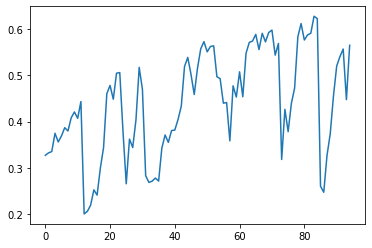

In [82]:
e = history4.history["val_dice_coeff"]
f = d+e
plt.plot(f)

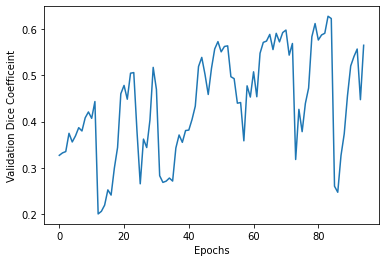

In [84]:
plt.plot(f)
plt.xlabel("Epochs")
plt.ylabel("Validation Dice Coefficeint")
plt.savefig("val_dice_coeff")

In [87]:
file = open("history1",'rb')
object_file1 = pickle.load(file)

file = open("history2",'rb')
object_file2 = pickle.load(file)

file = open("history3",'rb')
object_file3 = pickle.load(file)

file = open("history4",'rb')
object_file4 = pickle.load(file)


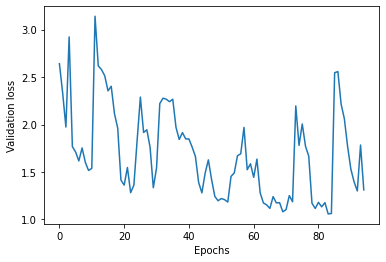

In [89]:
a = history.history['val_loss']
b = history2.history['val_loss']
c = history3.history['val_loss']
e = history4.history["val_loss"]
f = a+b+c+e
plt.plot(f)
plt.xlabel("Epochs")
plt.ylabel("Validation loss")
plt.savefig("val_loss")

In [39]:
model.load_weights('final/checkpoint')

In [52]:
history = model.evaluate(x=x[:100], y=y[:100], verbose=2)

In [53]:
history

[0.746395411491394, 0.7096064019203187]

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 

In [98]:
answer = model.predict(x[154:155])

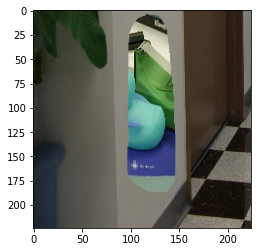

In [99]:
plt.imshow(x[154])

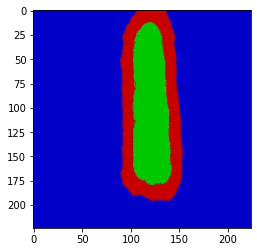

In [100]:
plt.imshow(y[154])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


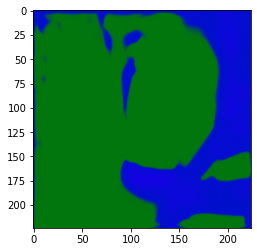

In [101]:
plt.imshow(answer[0])

In [84]:
result1 = y[50]
result2 = answer[0]

In [120]:
intersection = np.logical_and(result1, result2)
union = np.logical_or(result1, result2)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU is %s" % iou_score)

IoU is 0.45600818452380953


In [118]:
def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

In [120]:
y_pred1.shape

(150528, 1)

ValueError: Invalid reduction dimension 2 for input with 2 dimensions. for 'Sum_1' (op: 'Sum') with input shapes: [150528,1], [3] and with computed input tensors: input[1] = <1 2 3>.

In [57]:
import sklearn

In [59]:
len = 0
score=0
for i in range(0,100):
    y_true = y[i]
    y_pred = model.predict(x[i:i+1])
    result1 = np.reshape(y_true, (y_true.flatten().shape[0], 1))
    result2 = np.reshape(y_pred, (y_pred.flatten().shape[0], 1)) 
    intersection = np.logical_and(result1, result2)
    union = np.logical_or(result1, result2)
    iou_score = np.sum(intersection) / np.sum(union)
    len+=1

In [60]:
iou_score/100

0.003910767431972789

In [110]:
y_true =np.array([[+1, +1, +1, -1],[+1, -1, +1, +1]])
y_pred = np.array([[+1, -5, +1, +1],[+1, +5, +5, -1]])

In [111]:
y_true1 = np.reshape(y_true, (y_true.flatten().shape[0], 1))
y_pred1 = np.reshape(y_pred, (y_pred.flatten().shape[0], 1))


In [112]:
y_true.shape, y_pred.shape

((2, 4), (2, 4))

In [123]:
model.score(y_true1, y_pred1)

AttributeError: 'Model' object has no attribute 'score'

In [121]:
score = sklearn.metrics.matthews_corrcoef(y_true1, y_pred1)

ValueError: continuous is not supported

In [ ]:
score = sklearn.metrics.matthews_corrcoef

In [148]:
score

1.0

In [151]:
y[50].shape

(224, 224, 3)

In [152]:
answer[0].shape

(224, 224, 3)

In [155]:
sklearn.metrics.matthews_corrcoef(y[50], answer[0])

ValueError: unknown is not supported